<a href="https://colab.research.google.com/github/suhaaskarthik/landscape-colouriser/blob/main/anime_colour.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pathlib
import time
import datetime
from matplotlib import pyplot as plt
from IPython import display
import tensorflow as tf
tf.__version__

'2.13.0'

In [ ]:
def load_image(img_file):
  img = tf.io.read_file(img_file)
  img = tf.io.decode_jpeg(img)
  img = tf.image.resize(img, [256, 512])
  #print(img.shape)

  width = tf.shape(img)[1]
  #print(width)
  width = width // 2
  #print(width)
  transformed_img = img[:, :width, :]
  original_img = img[:, width:, :]

  original_img = tf.cast(original_img, tf.float32)
  transformed_img = tf.cast(transformed_img, tf.float32)

  return original_img, transformed_img

In [ ]:
import zipfile
from google.colab import drive


zip_ref = zipfile.ZipFile('drive/MyDrive/data.zip')
zip_ref.extractall()
zip_ref.close()

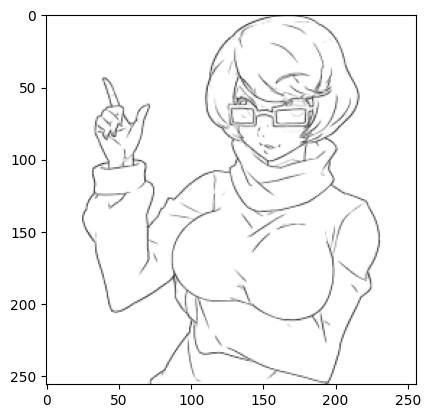

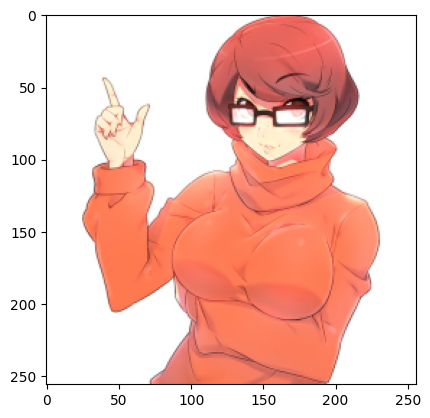

In [ ]:
original_img, transformed_img = load_image(str('train/1000000.png'))
plt.figure()
plt.imshow(original_img / 255.0)
plt.figure()
plt.imshow(transformed_img / 255.0);

In [ ]:
quantity_training = tf.data.Dataset.list_files(str('train/*.png'))
quantity_training = len(list(quantity_training))
quantity_training

14224

In [ ]:
import shutil
for i in os.listdir('val')[:3276]:
  shutil.move('val/'+i, 'train')

In [ ]:
import tfio

ModuleNotFoundError: ignored

In [ ]:
buffer_size = quantity_training
batch_size = 1
img_width = 256
img_height = 256

In [ ]:
def resize(original_img, transformed_img, width, height):
  original_img = tf.image.resize(original_img, [width, height], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  transformed_img = tf.image.resize(transformed_img, [width, height], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  return original_img, transformed_img

In [ ]:
def normalize(original_img, transformed_img):
  original_img = (original_img / 127.5) - 1
  transformed_img = (transformed_img / 127.5) - 1
  return original_img, transformed_img

In [ ]:
def random_crop(original_img, transformed_img):
  stacked_img = tf.stack([original_img, transformed_img], axis = 0)
  crop_img = tf.image.random_crop(stacked_img, size = [2, img_width, img_height, 3])
  return crop_img[0], crop_img[1]

In [ ]:
@tf.function()
def random_jitter(original_img, transformed_img):
  original_img, transformed_img = resize(original_img, transformed_img, 286, 286)
  original_img, transformed_img = random_crop(original_img, transformed_img)
  if tf.random.uniform(()) > 0.5:
    original_img = tf.image.flip_left_right(original_img)
    transformed_img = tf.image.flip_left_right(transformed_img)
  return original_img, transformed_img

In [ ]:
def load_training_images(img_file):
  original_img, transformed_img = load_image(img_file)
  original_img, transformed_img = random_jitter(original_img, transformed_img)
  original_img, transformed_img = normalize(original_img, transformed_img)
  return original_img, transformed_img

In [ ]:
def load_testing_images(img_file):
  original_img, transformed_img = load_image(img_file)
  original_img, transformed_img = resize(original_img, transformed_img, img_width, img_height)
  original_img, transformed_img = normalize(original_img, transformed_img)
  return original_img, transformed_img

In [ ]:
training_dataset = tf.data.Dataset.list_files(str('train/*.png'))
training_dataset = training_dataset.map(load_training_images, num_parallel_calls=tf.data.AUTOTUNE)
training_dataset = training_dataset.shuffle(buffer_size)
training_dataset = training_dataset.batch(batch_size)

In [ ]:
try:
  testing_dataset = tf.data.Dataset.list_files(str('val/*.png'))
except tf.errors.InvalidArgumentError:
  testing_dataset = tf.data.Dataset.list_files(str('val/*.png'))
testing_dataset = testing_dataset.map(load_testing_images)
testing_dataset = testing_dataset.batch(batch_size)

In [ ]:
def encode(filters, size, apply_batchnorm = True):
  initializer = tf.random_normal_initializer(0, 0.02)
  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2D(filters, size, strides = 2, padding = 'same',
                                    kernel_initializer=initializer, use_bias=False))
  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())
  result.add(tf.keras.layers.LeakyReLU())
  return result

In [ ]:
down_model = encode(3, 4)
down_result = down_model(tf.expand_dims(original_img, 0))
print(down_result.shape)

(1, 128, 128, 3)


In [ ]:
def decode(filters, size, apply_dropout = False):
  initializer = tf.random_normal_initializer(0, 0.02)
  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides = 2, padding = 'same',
                                             kernel_initializer=initializer, use_bias=False))
  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [ ]:
up_model = decode(3, 4)
up_result = up_model(down_result)
print(up_result.shape)

(1, 256, 256, 3)


In [ ]:
def Generator():
  inputs = tf.keras.layers.Input(shape = [256, 256, 3])

  downsampling = [
      encode(64, 4, apply_batchnorm = False), # (batch_size, 128, 128, 64)
      encode(128, 4), # (batch_size, 64, 64, 128)
      encode(256, 4), # (batch_size, 32, 32, 256)
      encode(512, 4), # (batch_size, 16, 16, 512)
      encode(512, 4), # (batch_size, 8, 8, 512)
      encode(512, 4), # (batch_size, 4, 4, 512)
      encode(512, 4), # (batch_size, 2, 2, 512)
      encode(512, 4), # (batch_size, 1, 1, 512)
  ]

  upsampling = [
      decode(512, 4, apply_dropout=True), # (batch_size, 2, 2, 512)
      decode(512, 4, apply_dropout=True), # (batch_size, 4, 4, 512)
      decode(512, 4, apply_dropout=True), # (batch_size, 8, 8, 512)
      decode(512, 4), # (batch_size, 16, 16, 512)
      decode(256, 4), # (batch_size, 32, 32, 256)
      decode(128, 4), # (batch_size, 64, 64, 128)
      decode(64, 4), # (batch_size, 128, 128, 64)
  ]

  output_channels = 3
  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(output_channels, 4, strides=2, padding='same',
                                         kernel_initializer=initializer, activation='tanh') # (batch_size, 256, 256, 3)

  x = inputs
  skips = []
  for down in downsampling:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  for up, skip in zip(upsampling, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs = inputs, outputs = x)

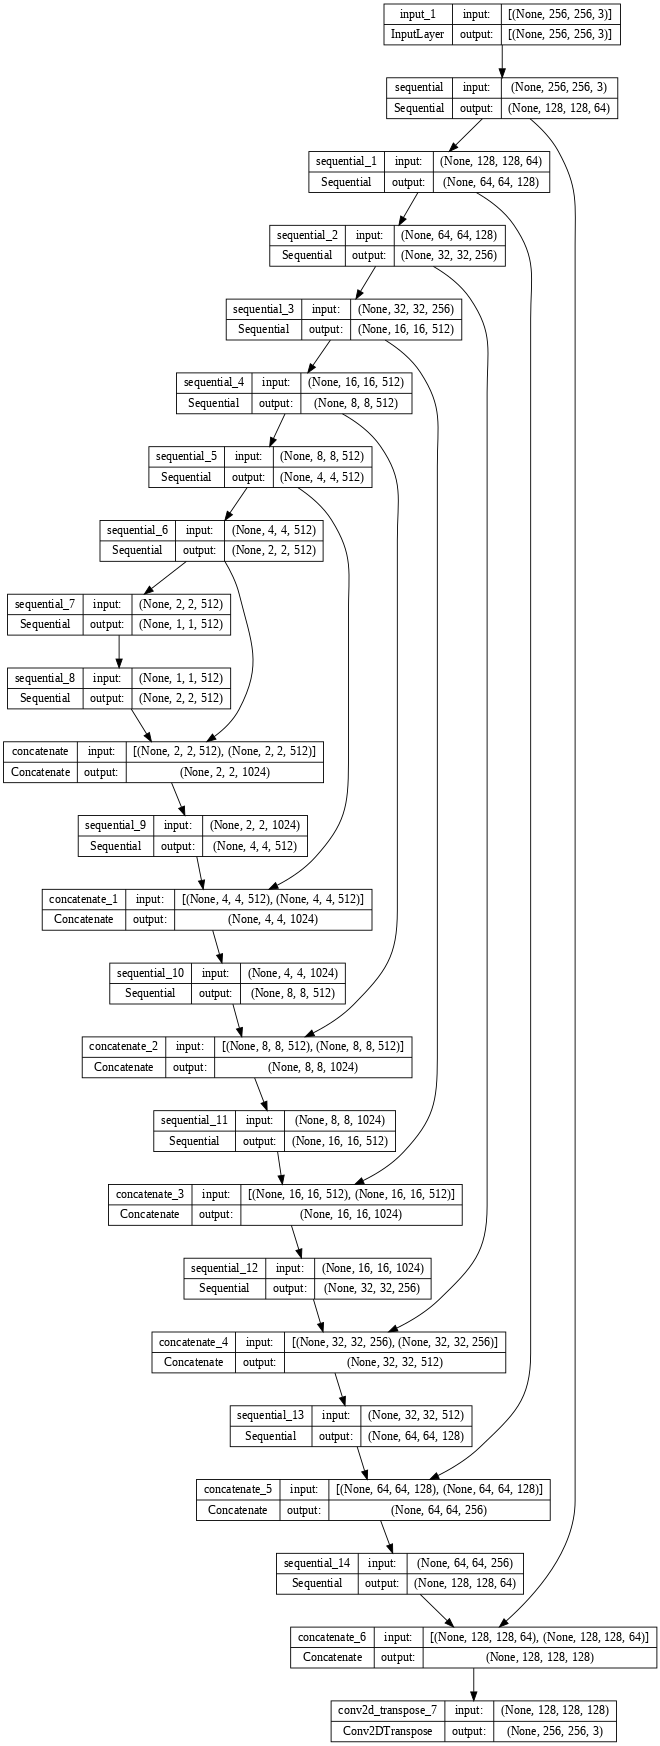

In [ ]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes = True, dpi = 64)

In [ ]:
lr = 0.0002
beta1, beta2 = 0.5, 0.999
lambda_ = 100

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [ ]:
def generator_loss(d_generated_output, g_output, target):
  gan_loss = loss(tf.ones_like(d_generated_output), d_generated_output)
  l1_loss = tf.reduce_mean(tf.abs(target - g_output)) # MAE
  g_loss_total = gan_loss + (lambda_ * l1_loss)
  return g_loss_total, gan_loss, l1_loss

In [ ]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  original = tf.keras.layers.Input(shape = [256,256,3], name='original_img')
  transformed = tf.keras.layers.Input(shape=[256,256,3], name='transformed_img')
  x = tf.keras.layers.concatenate([original, transformed]) # (batch_size, 256, 256, channels * 2)

  down1 = encode(64, 4, False)(x) # (batch_size, 128, 128, 64)
  down2 = encode(128, 4)(down1) # (batch_size, 64, 64, 128)
  down3 = encode(256, 4)(down2) # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides = 1, kernel_initializer=initializer, use_bias=False)(zero_pad1) # (batch_size, 31, 31, 512)
  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (batch_size, 33, 33, 512)
  last = tf.keras.layers.Conv2D(1, 4, strides = 1, kernel_initializer=initializer)(zero_pad2) # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs = [original, transformed], outputs = last)

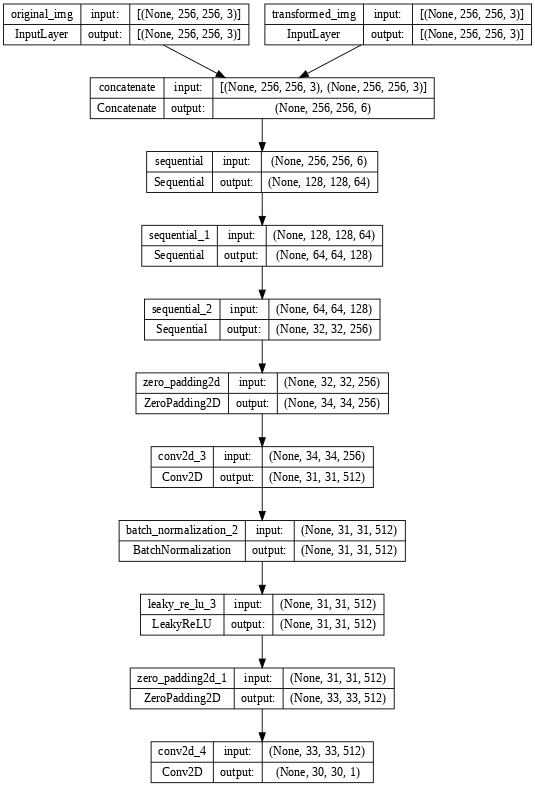

In [ ]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes = True, dpi = 64)

In [ ]:
def discriminator_loss(d_real_output, d_generated_output):
  real_loss = loss(tf.ones_like(d_real_output), d_real_output)
  generated_loss = loss(tf.zeros_like(d_generated_output), d_generated_output)
  d_total_loss = real_loss + generated_loss
  return d_total_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(lr, beta_1 = beta1, beta_2 = beta2)
discriminator_optimizer = tf.keras.optimizers.Adam(lr, beta_1 = beta1, beta_2 = beta2)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

In [ ]:
def generate_images(model, test_input, real, step = None):
  generated_img = model(test_input, training=True)
  plt.figure(figsize=(12,8))

  img_list = [test_input[0], real[0], generated_img[0]]
  title = ['Input image', 'Real (ground truth)', 'Generated image (fake)']

  for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(title[i])
    plt.imshow(img_list[i] * 0.5 + 0.5)
    plt.axis('off')

  if step is not None:
    plt.savefig('result_pix2pix_step_{}.png'.format(step), bbox_inches='tight')

  plt.show()

In [ ]:
path_log = 'logs/'
metrics = tf.summary.create_file_writer(path_log + 'fit/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
@tf.function
def training_step(input_img, real, step):
  with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
    g_output = generator(input_img, training = True)

    d_output_real = discriminator([input_img, real], training = True)
    d_output_generated = discriminator([input_img, g_output], training = True)

    g_total_loss, g_loss_gan, g_loss_l1 = generator_loss(d_output_generated, g_output, real)
    d_loss = discriminator_loss(d_output_real, d_output_generated)

  generator_gradients = g_tape.gradient(g_total_loss, generator.trainable_variables)
  discriminator_gradients = d_tape.gradient(d_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

  with metrics.as_default():
    tf.summary.scalar('g_total_loss', g_total_loss, step=step//1000)
    tf.summary.scalar('g_loss_gan', g_loss_gan, step=step//1000)
    tf.summary.scalar('g_loss_l1', g_loss_l1, step=step//1000)
    tf.summary.scalar('d_loss', d_loss, step=step//1000)

In [ ]:
def train(training_dataset, testing_dataset, steps):
  test_input, real_input = next(iter(testing_dataset.take(1)))
  start = time.time()

  for step, (input_img, real_img) in training_dataset.repeat().take(steps).enumerate():
    if step % 1000 == 0:
      display.clear_output(wait = True)
      if step != 0:
        print(f'Time taken to run 1000 steps: {time.time() - start:.2f} seconds\n')
      start = time.time()
      generate_images(generator, test_input, real_input, step)
      print(f'Step: {step//1000}K')
    training_step(input_img, real_img, step)
    if (step + 1) % 10 == 0:
      print('.', end = '', flush = True)
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)
      generator.save_weights('drive/MyDrive/model_pix2pix.h5')

Time taken to run 1000 steps: 14.74 seconds



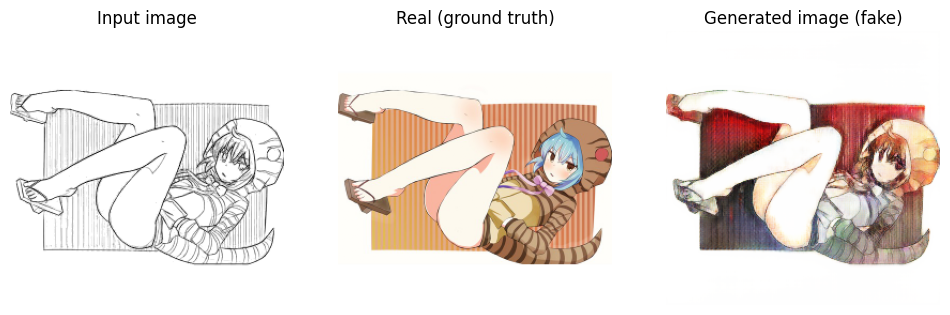

Step: 79K
....................................................................................................

In [ ]:
train(training_dataset, testing_dataset, steps = 80000)

In [ ]:
tf.train.latest_checkpoint(checkpoint_dir)

'./training_checkpoints/ckpt-8'

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
model2 = Generator()
model2.load_weights('drive/MyDrive/model_pix2pix.h5')

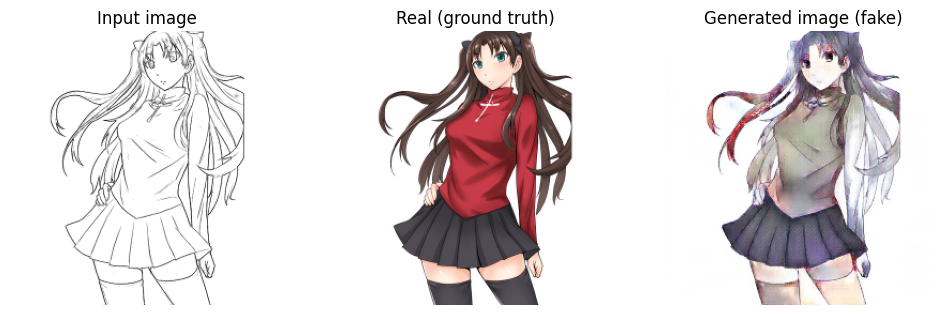

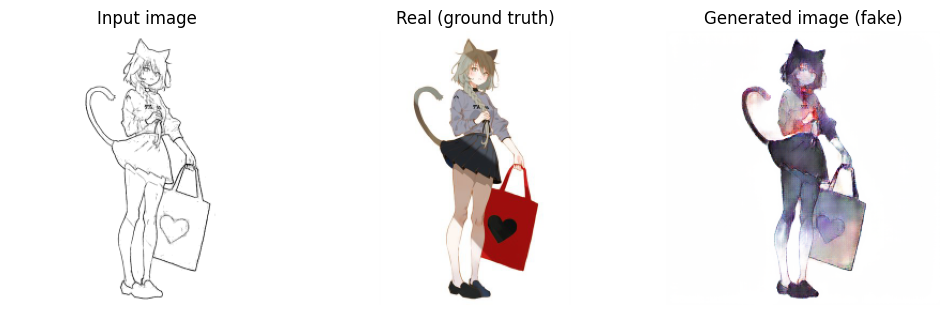

In [ ]:
for s, m in testing_dataset.take(2):
  generate_images(model2, s, m)